# Produce plots comparing the spring/neap cycle wityh the timeseries of winds, surface current speeds and surface salinity at the three chosen locations. 
## Includes functionality for running means, and the ability to zoom into a time window to get a more detaled look at what is happining within a chosen time window.

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import xarray as xr
import pickle
import time
import datetime
from scipy.signal import butter, lfilter
%matplotlib inline

## Create Variables
### Disclaimer: I wrote this in a quite incomprehinsible way originally. 
### I have made life easier by making netcdf files instead of using variables
### For making profiles in the future, I recommend following the recipe in Make_profile.ipynb

## Skip to Create Plots below to make the plots from existing netcdf files

In [2]:
ssh = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSgSurfaceTracerFields1hV18-06")

In [3]:
times_ssh = ssh.time.sel(time = ssh.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[D]').astype(datetime.datetime)

In [4]:
data = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSgNearSurfaceUVelocity20mV18-06")

In [5]:
times_current = data.time.sel(time = data.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[s]').astype(datetime.datetime)

In [6]:
winddata = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1")
wind_times = winddata.time.values.astype('datetime64[s]').astype(datetime.datetime)

#### Current Variables

In [7]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/current speed/3points20m/current_sog{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["current_sog" + str(year)] = pickle.load(file)
    locals()["t_sog" + str(year)] = []
    for time in times_current: 
        if time.year == year:
            locals()["t_sog" + str(year)].append(time)

In [8]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/current speed/3points20m/current_salmon{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["current_salmon" + str(year)] = pickle.load(file)
    locals()["t_salmon" + str(year)] = []
    for time in times_current: 
        if time.year == year:
            locals()["t_salmon" + str(year)].append(time)

In [9]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/current speed/3points20m/current_turn{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["current_turn" + str(year)] = pickle.load(file)
    locals()["t_turn" + str(year)] = []
    for time in times_current: 
        if time.year == year:
            locals()["t_turn" + str(year)].append(time)

In [34]:
tsog = np.concatenate([t_sog2015, t_sog2016, t_sog2017, t_sog2018])
currsog = np.concatenate([current_sog2015, current_sog2016, current_sog2017, current_sog2018])
tsal = np.concatenate([t_salmon2015, t_salmon2016, t_salmon2017, t_salmon2018])
currsal = np.concatenate([current_salmon2015, current_salmon2016, current_salmon2017, current_salmon2018])
tturn = np.concatenate([t_turn2015, t_turn2016, t_turn2017, t_turn2018])
currturn = np.concatenate([current_turn2015, current_turn2016, current_turn2017, current_turn2018])
currents = xr.Dataset({'SOG': xr.DataArray(currsog, coords = [tsog], dims = ['time']), 
               'salmon': xr.DataArray(currsal, coords = [tsal], dims = ['time']),
               'turnpoint': xr.DataArray(currturn, coords = [tturn], dims = ['time'])})
currents.to_netcdf('current_speed_timeseries.nc', format = 'NETCDF4',engine = 'netcdf4')

#### SSH Variables

In [10]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/SSH/3points/ssh_sog{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["ssh_sog" + str(year)] = pickle.load(file)
    locals()["tssh_sog" + str(year)] = []
    for time in times_ssh: 
        if time.year == year:
            locals()["tssh_sog" + str(year)].append(time)

In [11]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/SSH/3points/ssh_salmon{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["ssh_salmon" + str(year)] = pickle.load(file)
    locals()["tssh_salmon" + str(year)] = []
    for time in times_ssh: 
        if time.year == year:
            locals()["tssh_salmon" + str(year)].append(time)

In [12]:
for year in [2015, 2016, 2017, 2018]:
    fname = "/home/abhudia/Desktop/SSH/3points/ssh_turn{}.pickle".format(str(year))
    file = open(fname, "rb")
    locals()["ssh_turn" + str(year)] = pickle.load(file)
    locals()["tssh_turn" + str(year)] = []
    for time in times_ssh: 
        if time.year == year:
            locals()["tssh_turn" + str(year)].append(time)

In [49]:
sshtsog = np.concatenate([tssh_sog2015, tssh_sog2016, tssh_sog2017, tssh_sog2018]).astype('datetime64[s]')
sshsog= np.concatenate([ssh_sog2015, ssh_sog2016, ssh_sog2017, ssh_sog2018])
sshtsal = np.concatenate([tssh_salmon2015, tssh_salmon2016, tssh_salmon2017, tssh_salmon2018]).astype('datetime64[s]')
sshsal= np.concatenate([ssh_salmon2015, ssh_salmon2016, ssh_salmon2017, ssh_salmon2018])
sshtturn = np.concatenate([tssh_turn2015, tssh_turn2016, tssh_turn2017, tssh_turn2018]).astype('datetime64[s]')
sshturn = np.concatenate([ssh_turn2015, ssh_turn2016, ssh_turn2017, ssh_turn2018])
ssh = xr.Dataset({'SOG': xr.DataArray(sshsog, coords = [sshtsog], dims = ['time']), 
               'salmon': xr.DataArray(sshsal, coords = [sshtsal], dims = ['time']),
               'turnpoint': xr.DataArray(sshturn, coords = [sshtturn], dims = ['time'])})
ssh.to_netcdf('ssh_timeseries.nc', format = 'NETCDF4',engine = 'netcdf4')

#### Wind Variables

In [13]:
years = [2015,2016,2017,2018]
abbrs = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
locs = ['salmon' ,'turn', 'sog']
for year in [2015, 2016, 2017, 2018]:
    for loc in locs:
        fname = "/home/abhudia/Desktop/Wind speed/3points/winds_{}{}.pickle".format(loc, str(year))
        file = open(fname, "rb") 
        locals()["winds_{}".format(loc) + str(year)] = pickle.load(file)
        locals()["twind_{}".format(loc) + str(year)] = []
        for time in wind_times: 
            if time.year == year:
                locals()["twind_{}".format(loc) + str(year)].append(time)

In [50]:
wtsog = np.concatenate([twind_sog2015, twind_sog2016, twind_sog2017, twind_sog2018])
wsog= np.concatenate([winds_sog2015, winds_sog2016, winds_sog2017, winds_sog2018])
wtsal = np.concatenate([twind_salmon2015, twind_salmon2016, tssh_salmon2017, tssh_salmon2018])
wsal= np.concatenate([winds_salmon2015, winds_salmon2016, winds_salmon2017, winds_salmon2018])
wtturn = np.concatenate([twind_turn2015, twind_turn2016, twind_turn2017, twind_turn2018])
wturn = np.concatenate([winds_turn2015, winds_turn2016, winds_turn2017, winds_turn2018])
winds = xr.Dataset({'SOG': xr.DataArray(wsog, coords = [wtsog], dims = ['time']), 
               'salmon': xr.DataArray(wsal, coords = [wtsog], dims = ['time']),
               'turnpoint': xr.DataArray(wturn, coords = [wtsog], dims = ['time'])})
winds.to_netcdf('wind_speed_timeseries.nc', format = 'NETCDF4',engine = 'netcdf4')

#### Salinity Variables

In [14]:
salinity = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV18-06")
times_salinity = salinity.time.sel(time = salinity.time.dt.year.isin([2015,2016,2017,2018])).values.astype('datetime64[s]').astype(datetime.datetime)

In [15]:
locs = ['sog', 'salmon', 'turn']
for loc in locs:
    for year in [2015, 2016, 2017, 2018]:
        fname = "/home/abhudia/Desktop/salinity/3points/{}{}.pickle".format(loc, str(year))
        file = open(fname, "rb")
        locals()[loc + "sal" + str(year)] = pickle.load(file)
        locals()["tsal" + str(year)] = []
        for time in times_salinity: 
            if time.year == year:
                locals()["tsal" + str(year)].append(time)  

In [51]:
saltsog = np.concatenate([tsal2015, tsal2016, tsal2017, tsal2018])
salsog= np.concatenate([sogsal2015, sogsal2016, sogsal2017, sogsal2018])
saltsal = np.concatenate([tsal2015, tsal2016, tsal2017, tsal2018])
salsal= np.concatenate([salmonsal2015, salmonsal2016, salmonsal2017, salmonsal2018])
saltturn = np.concatenate([tsal2015, tsal2016, tsal2017, tsal2018])
salturn = np.concatenate([turnsal2015, turnsal2016, turnsal2017, turnsal2018])
salinity = xr.Dataset({'SOG': xr.DataArray(salsog, coords = [saltsog], dims = ['time']), 
               'salmon': xr.DataArray(salsal, coords = [saltsog], dims = ['time']),
               'turnpoint': xr.DataArray(salturn, coords = [saltsog], dims = ['time'])})
salinity.to_netcdf('surface_salinity_timeseries.nc', format = 'NETCDF4',engine = 'netcdf4')

### Function Definitions

In [10]:
## Array List/Array -> Listof(Array, Array)
## produce a list where first element is listof Days and second element is listof (Max-Min ssh)
def ssh_amplitudes(ssh_array, times):
    # Returns only one copy of each day, and count of times each day appears
    unique, counts = np.unique(times, return_counts=True) 
    mins = []; maxes = []
    index = 0
    
    # for the numbers of hours in a day, determine the min and max ssh that day
    for count in counts:
        initial = ssh_array[index]
        day_min = initial; day_max = initial
      
        while count != 0:
            ssh = ssh_array[index]
            if ssh < day_min:
                day_min = ssh
            if ssh > day_max:
                day_max = ssh
            index = index + 1
            count = count - 1
            
        # add these values to the lists of max and min ssh    
        mins.append(day_min); maxes.append(day_max)
    
    return([unique, np.asarray(maxes)-np.asarray(mins)])   


In [11]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [12]:
def average_output(data_array, times, period):
    """average output by period, e.g. 's', 'd', 'm', 'y'
    """
    unique, counts = np.unique(np.asarray(times).astype('datetime64[{}]'.format(period)).astype(datetime.datetime), return_counts=True) 
    index = 0; count_so_far = 0; means = []
    
    for count in counts:
        means.append(np.sum(data_array[count_so_far: count_so_far + count])/count)
        count_so_far = count_so_far + count
        
    return([unique, means])  

## Create Plots

In [13]:
# load netcdf profiles
currents = xr.open_dataset('current_speed_timeseries.nc')
ssh = xr.open_dataset('ssh_timeseries.nc')
winds = xr.open_dataset('wind_speed_timeseries.nc')
salinity = xr.open_dataset('surface_salinity_timeseries.nc')

In [14]:
ssh

<xarray.Dataset>
Dimensions:    (time: 35064)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-01 ... 2018-12-31
Data variables:
    SOG        (time) float32 ...
    salmon     (time) float32 ...
    turnpoint  (time) float32 ...

In [25]:
# time to center at
center = datetime.datetime(2017,12,1, 0,0,0)
# number of days to plot up on either side of this center time
delta = datetime.timedelta(days = 7)
# title of chart
suptitle = 'SOG12117'
# number of hours by whcih to take the running mean for the current speeds
current_running_mean_window = 72
# number of hours by whcih to take the running mean for the wind speeds
wind_running_mean_window = 14
# save the output as this file
outfile = 'SOG12117.png'

def timeseries_plot(location, center, delta, suptitle, current_running_mean_window, wind_running_mean_window, outfile):
    begin, end = center - delta, center + delta
    suptitle = suptitle + ": " + str(begin) + ' - ' + str(end)
    fig = plt.figure(figsize = (16,9))

    # spring-Neap Cycle
    ax1 = plt.subplot(4,1,1)
    if location is 'SoG':
        ssh_values = ssh.SOG.values
    elif location is 'Turn Point':
        ssh_values = ssh.turnpoint.values
    elif location in 'Salmon Bank':
        ssh_values = ssh.salmon.values
    data_times = ssh.time.values
    times, spring_neap = ssh_amplitudes(ssh_values, data_times)
    plt.plot(times, spring_neap)
    ax1.set_ylim(spring_neap.min(), spring_neap.max())
    plt.hlines(np.mean(spring_neap), times[0], times[-1], label = 'Average for full record', linestyles='solid')
    plt.title(f'Max - Min SSH by day at {location} [m]')
    plt.ylabel('Max - Min SSH by day [m]')
    plt.legend()

    # wind speeds
    ax2 = plt.subplot(4,1,2)
    if location is 'SoG':
        data = winds.SOG.values
    elif location is 'Turn Point':
        data = winds.turnpoint.values
    elif location in 'Salmon Bank':
        data = winds.salmon.values
    data_times = winds.time.values
    avg_values = running_mean(data, wind_running_mean_window)
    avg_times = data_times[int(wind_running_mean_window/2): int(data_times.shape[0] - wind_running_mean_window/2 +1)]
    plt.plot(data_times, data, label = 'Raw')
    plt.plot(avg_times, avg_values, label = f'Running mean, window of {wind_running_mean_window} hours')
    plt.hlines(np.mean(data), data_times[0], data_times[-1], label = 'Average for full record', linestyles='solid')
    ax2.set_ylim(data.min(), data.max())
    plt.title(f'Wind speed at {location} [m/s]')
    plt.ylabel('wind speed [m/s]')
    plt.legend()

    # surface current speeds
    ax3 = plt.subplot(4,1,3)
    if location is 'SoG':
        data = currents.SOG.values
    elif location is 'Turn Point':
        data = currents.turnpoint.values
    elif location in 'Salmon Bank':
        data = currents.salmon.values
    data = currents.SOG.values
    data_times = currents.time.values
    avg_values = running_mean(data, current_running_mean_window)
    avg_times = data_times[int(current_running_mean_window/2): int(data_times.shape[0] - current_running_mean_window/2 +1)]
    plt.plot(data_times, data, label = 'Raw')
    plt.plot(avg_times, avg_values, label = f'Running mean, window of {current_running_mean_window} hours')
    plt.hlines(np.mean(data), data_times[0], data_times[-1], label = 'Average for full record', linestyles='solid')
    ax3.set_ylim(data.min(), data.max())
    plt.title(f'Surface current speed at {location} [m/s]')
    plt.ylabel('Surface Current speed [m/s]')
    plt.legend()

    # surface salinity
    ax4 = plt.subplot(4,1,4)
    if location is 'SoG':
        data = salinity.SOG.values
    elif location is 'Turn Point':
        data = salinity.turnpoint.values
    elif location in 'Salmon Bank':
        data = salinity.salmon.values
    data_times = salinity.time.values
    plt.plot(data_times, data, label= 'Raw')
    ax4.set_ylim(data.min(), data.max())
    plt.hlines(np.mean(data), data_times[0], data_times[-1], label = 'Average for full record', linestyles='solid')
    plt.title(f'Surface Salinity at {location} [g kg-1]')
    plt.ylabel('Surface Salinity [g kg-1]')
    plt.legend()

    plt.tight_layout()

    for axis in (ax1, ax2, ax3, ax4):
        axis.set_xlim([begin, end])

    plt.suptitle(suptitle, y=1.02)
    plt.savefig(outfile)

###  Example Usage

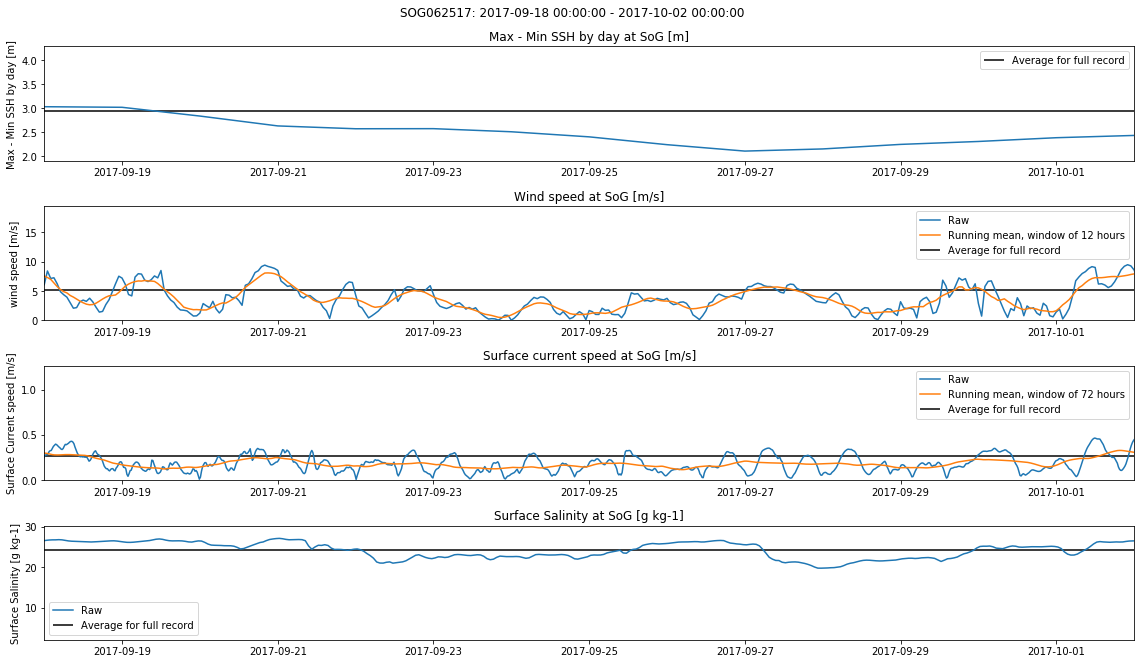

In [26]:
timeseries_plot('SoG', 
                datetime.datetime(2017,9,25, 0,0,0), 
                datetime.timedelta(days = 7), 
                'SOG062517', 
                72, 
                12,
                'Plots/SOG12117.png'
               )